In [39]:
import librosa
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

from IPython.display import Audio
from scipy.signal import stft
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch import nn, optim
from umap import UMAP

In [40]:
sr = 22050
window = 512
random_state = 100
test_size = 0.2
torch.manual_seed(random_state)
batch_size = 100
lr = 0.0001
epochs = 30

In [61]:
def get_file(file_name):
    return librosa.load('archive/wavfiles/' + file_name, sr=sr)

df = pd.read_csv('archive/bird_songs_metadata.csv')[['name', 'filename']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      5422 non-null   object
 1   filename  5422 non-null   object
dtypes: object(2)
memory usage: 84.8+ KB


In [44]:
bird_names = df['name'].unique()
encoder = LabelEncoder()
encoder.fit(bird_names)
print(bird_names)

["Bewick's Wren" 'Northern Mockingbird' 'American Robin' 'Song Sparrow'
 'Northern Cardinal']


In [49]:
X = []
y = []
for i, row in df.iterrows():
    audio, sr = get_file(row['filename'])
    _, _, spectrogram = stft(audio, fs=sr, window='hann', nperseg=window, noverlap=window * 0.5)
    X.append(np.abs(spectrogram))
    y.append(torch.tensor(encoder.transform([row['name']])[0], dtype=torch.long))

In [60]:
def create_block(dim_in: int, dim_out: int, kernel_size: int = 5, padding: int = 2) -> nn.Module:
    return nn.Sequential(
        nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )

model = nn.Sequential(
    create_block(1, 10, kernel_size=5),
    create_block(10, 20, kernel_size=5),
    create_block(20, 40, kernel_size=5),
    nn.Flatten(),
    nn.Linear(40 * 64 * 16, 1000),
    nn.Linear(1000, 5),
)

train, test = train_test_split(list(zip(X, y)), test_size=test_size, random_state=random_state)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0.0
    with torch.no_grad():
        for data, target in loader:
            data = data.unsqueeze(1)
            outputs = model(data)
            loss = criterion(outputs, target)
            loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += 1
            if predicted == target:
                correct += 1

    return 100. * correct / total, loss / len(loader)

In [11]:
def train(model, loader):
    i = 0
    local_loss = []
    local_acc = []
    for epoch in range(epochs):
        model.train()
        for data, target in loader:
            data = data.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            i += 1

        epoch_acc, epoch_loss = test(model, test_loader)
        local_loss.append(epoch_loss)
        local_acc.append(epoch_acc)
        torch.save(model.state_dict(), 'models/model-{}.pth'.format(epoch + 1))
        
        print('Epoch [{}/{}], iteration:[{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
            epoch + 1, epochs, 
            i, 
            epoch_loss, epoch_acc))
    print('Result: Epochs: {}, Iterations: {}, Loss: {:.4f}, Accuracy: {:.2f}%'.format(
        epochs,
        i,
        local_loss[-1],
        local_acc[-1]))

In [12]:
train(model, train_loader)

Epoch [1/30], iteration:[44], Loss: 0.2893, Accuracy: 21.20%
Epoch [2/30], iteration:[88], Loss: 0.2787, Accuracy: 47.93%
Epoch [3/30], iteration:[132], Loss: 0.2218, Accuracy: 51.89%
Epoch [4/30], iteration:[176], Loss: 0.1912, Accuracy: 55.30%
Epoch [5/30], iteration:[220], Loss: 0.1922, Accuracy: 59.17%
Epoch [6/30], iteration:[264], Loss: 0.1997, Accuracy: 56.96%
Epoch [7/30], iteration:[308], Loss: 0.1752, Accuracy: 59.35%
Epoch [8/30], iteration:[352], Loss: 0.1754, Accuracy: 61.38%
Epoch [9/30], iteration:[396], Loss: 0.1803, Accuracy: 62.49%
Epoch [10/30], iteration:[440], Loss: 0.1633, Accuracy: 62.30%
Epoch [11/30], iteration:[484], Loss: 0.1805, Accuracy: 64.15%
Epoch [12/30], iteration:[528], Loss: 0.1814, Accuracy: 65.16%
Epoch [13/30], iteration:[572], Loss: 0.1796, Accuracy: 66.08%
Epoch [14/30], iteration:[616], Loss: 0.1845, Accuracy: 65.62%
Epoch [15/30], iteration:[660], Loss: 0.1630, Accuracy: 66.45%
Epoch [16/30], iteration:[704], Loss: 0.1801, Accuracy: 67.47%
Epo

In [66]:
model.load_state_dict(torch.load('models/model-29.pth'))

<All keys matched successfully>

In [77]:
classifier = nn.Sequential(*list(model.children())[:-1])
classifier.eval()

num_birds = 1000
birds_left = {}

random_indexes = torch.randperm(len(X))[:num_birds]
rand_X = np.array(X)[random_indexes]
rand_y = np.array(y)[random_indexes]

embeddings = []
birds_count = {}

for data in rand_X:
    data = torch.from_numpy(data).unsqueeze(0).unsqueeze(0)
    output = classifier(data).detach().numpy()
    embeddings.append(output)
    
for name in rand_y:
    birds_count.setdefault(encoder.classes_[name], 0)    
    birds_count[encoder.classes_[name]] += 1
    
print(birds_count)

embeddings = np.concatenate(embeddings)

{"Bewick's Wren": 149, 'Song Sparrow': 240, 'Northern Cardinal': 179, 'American Robin': 190, 'Northern Mockingbird': 242}


In [78]:
plt_data = pd.DataFrame(UMAP(random_state=random_state).fit_transform(embeddings), columns=['x', 'y'])
plt_data['name'] = [encoder.classes_[name] for name in rand_y]

fig = px.scatter(plt_data, x='x', y='y', color='name')
fig.show()

/Users/ubeleynoe/Projects/itmo/6th-semester/lab4/venv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [79]:
def get_distance(i, j):
    return np.linalg.norm(embeddings[i] - embeddings[j])

def show_file(i):
    i = random_indexes[i].item()
    name = df.iloc[i]['name']
    filename = df.iloc[i]['filename']
    ax = sns.heatmap(np.log(X[i]))
    ax.set_title(name + ' ' + filename)
    plt.show()
    
    audio_file, _ = get_file(filename)
    display(Audio(audio_file, rate=sr))

Top-3 similar birds:
Bird names: Northern Mockingbird Bewick's Wren, Distance: 0.5561114549636841


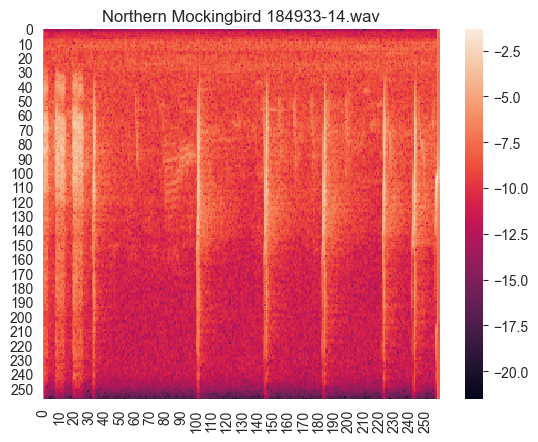

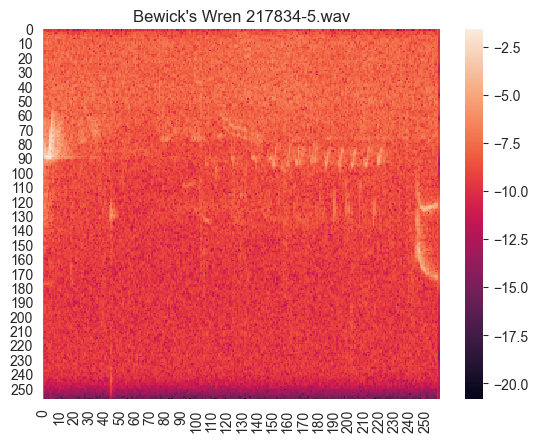

Bird names: Bewick's Wren Song Sparrow, Distance: 0.5570582747459412


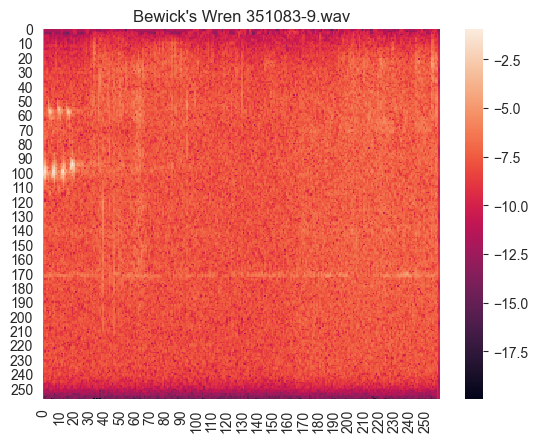

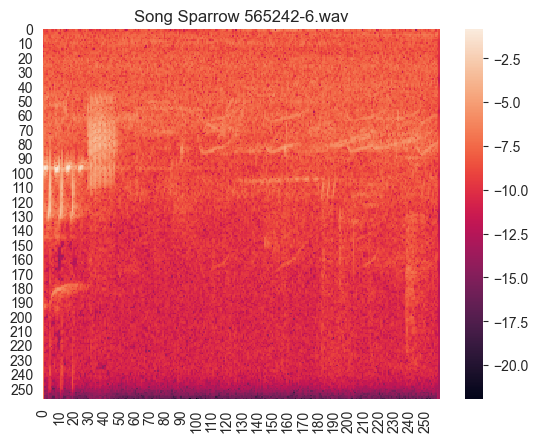

Bird names: Bewick's Wren Northern Cardinal, Distance: 0.7634891867637634


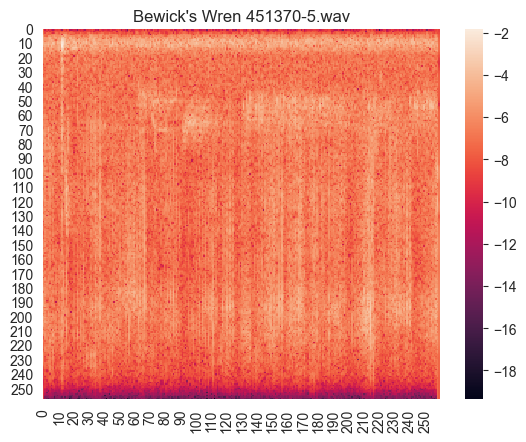

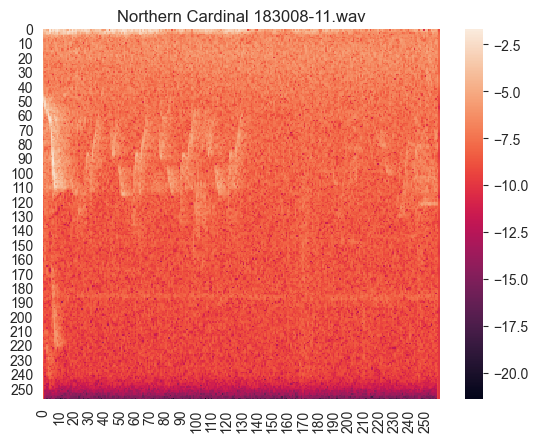

In [80]:
similar_birds = [[0, 1, get_distance(0, 1)] for _ in range(3)]

for i in range(num_birds):
    for j in range(i + 1, num_birds):
        if plt_data.iloc[i]['name'] != plt_data.iloc[j]['name']:
            distance = get_distance(i, j)
            if distance < similar_birds[0][2]:
                similar_birds[2] = similar_birds[1]
                similar_birds[1] = similar_birds[0]
                similar_birds[0] = [i, j, distance]
            elif distance < similar_birds[1][2]:
                similar_birds[2] = similar_birds[1]
                similar_birds[1] = [i, j, distance]           
            elif distance < similar_birds[2][2]:
                similar_birds[2] = [i, j, distance]
    
print('Top-3 similar birds:')     
for i, j, distance in similar_birds:
    print('Bird names: {} {}, Distance: {}'.format(
        plt_data.iloc[i]['name'], plt_data.iloc[j]['name'],
        distance))
    show_file(i)
    show_file(j)